# Fine-tuning a model for Sentence Similarity and Information Retrieval

In this notebook, we will fine-tune a sentence transformer model for document similarity tasks, specifically for the RepositoriUM collection. We'll use a pre-trained model and fine-tune it on pairs of document abstracts with similarity scores.

The completed system will allow us to:
1. Process document collections from RepositoriUM
2. Train a similarity model on document pairs
3. Retrieve relevant documents based on a query

In [1]:
# Install required packages
!pip install datasets transformers sentence-transformers pandas numpy tqdm evaluate huggingface_hub torch


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Install accelerate package for PyTorch training support
!pip install 'accelerate>=0.26.0'


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import transformers
import sentence_transformers
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/tomas/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [4]:
from transformers.utils import send_example_telemetry

send_example_telemetry("sentence_similarity_notebook", framework="pytorch")

## Configuring the Model

We'll set the parameters for our model training. For best results in sentence similarity tasks, we should use a pre-trained sentence-transformer model:

In [5]:
# Model configuration
model_checkpoint = "paraphrase-multilingual-MiniLM-L12-v2"
batch_size = 16  # Adjust based on your GPU memory
max_length = 512  # Maximum sequence length

# Training parameters
num_epochs = 4  # Number of training epochs (adjust as needed)
warmup_ratio = 0.1  # Percentage of steps for warmup
learning_rate = 2e-5  # Learning rate for training

print(f"Selected model: {model_checkpoint}")
print(f"Training parameters: {num_epochs} epochs, batch size {batch_size}, learning rate {learning_rate}")

Selected model: paraphrase-multilingual-MiniLM-L12-v2
Training parameters: 4 epochs, batch size 16, learning rate 2e-05


## Loading the Dataset

First, we need to load the training data that was created by our `process_data.py` script.
This data consists of pairs of document abstracts with similarity scores.

In [6]:
import json
import pandas as pd
import os
from pathlib import Path

# Load the training data
data_dir = Path("data")
train_file = data_dir / "training_data.json"

try:
    with open(train_file, 'r', encoding='utf-8') as f:
        training_data = json.load(f)

    print(f"Loaded {len(training_data)} document pairs")
    
    # Convert to DataFrame for easier handling
    # Make sure we handle the data consistently as lists
    train_df = pd.DataFrame([
        {"abstract1": item[0], "abstract2": item[1], "similarity": float(item[2])}
        for item in training_data
    ])

except Exception as e:
    print(f"Error loading training data: {e}")
    print("Please run process_data.py first to create the training data, or check the file path")

Loaded 500 document pairs


Let's examine the distribution of similarity scores to understand our data better:

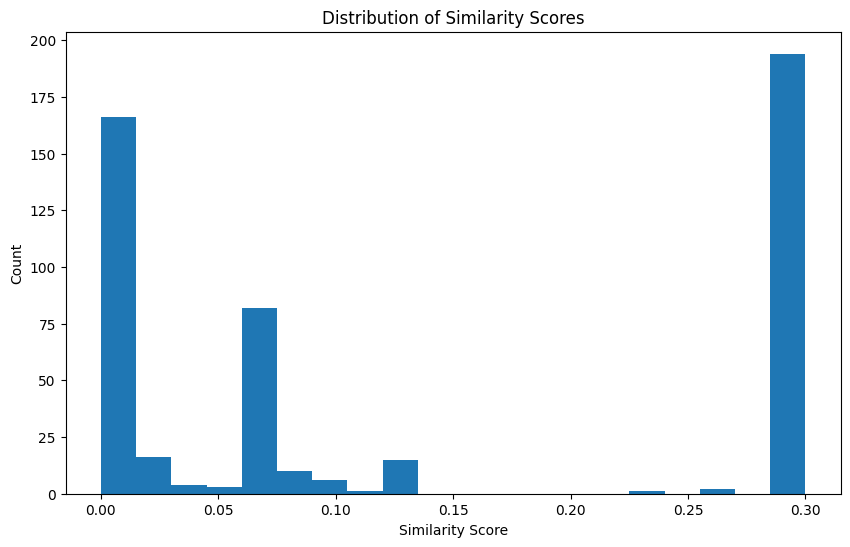

Min similarity: 0.0
Max similarity: 0.3
Mean similarity: 0.1371096928071928
Median similarity: 0.06666666666666667


In [7]:
import matplotlib.pyplot as plt

# Check if we have enough data
if len(train_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(train_df['similarity'], bins=20)
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Count')
    plt.show()

    print(f"Min similarity: {train_df['similarity'].min()}")
    print(f"Max similarity: {train_df['similarity'].max()}")
    print(f"Mean similarity: {train_df['similarity'].mean()}")
    print(f"Median similarity: {train_df['similarity'].median()}")
else:
    print("Not enough data to display similarity distribution.")

Now, let's prepare the data for training by splitting it into training and validation sets:

In [8]:
from sklearn.model_selection import train_test_split

# Check if we have enough data for a valid split
if len(train_df) < 10:
    print("Warning: Not enough data for a meaningful split. Consider generating more data.")
    # Create a simple split for demonstration
    train_data = train_df.iloc[:int(len(train_df)*0.8)]
    val_data = train_df.iloc[int(len(train_df)*0.8):]
else:
    # Split data into train and validation sets
    train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training data: {len(train_data)} pairs")
print(f"Validation data: {len(val_data)} pairs")

# Check if we have a reasonable amount of training data
if len(train_data) < 100:
    print("\nWARNING: Training with a small dataset may lead to poor model performance.")
    print("Consider collecting more data for better results.")

Training data: 400 pairs
Validation data: 100 pairs


## Preparing the Model for Training

In [9]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import torch
import time

# Set the device for the model
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device_str}")

try:
    # Load pretrained sentence-transformer model
    model = SentenceTransformer(model_checkpoint, device=device_str)
    print(f"Model successfully loaded: {model}")
    
    # Check model's current device
    print(f"Model is on device: {next(model.parameters()).device}")

    # Prepare training examples
    train_examples = []
    for _, row in train_data.iterrows():
        # Convert to string if not already
        abstract1 = str(row['abstract1']) if not isinstance(row['abstract1'], str) else row['abstract1']
        abstract2 = str(row['abstract2']) if not isinstance(row['abstract2'], str) else row['abstract2']
        
        # Create input example with properly formatted texts
        train_examples.append(InputExample(
            texts=[abstract1, abstract2],
            label=float(row['similarity'])
        ))

    # Prepare validation examples
    val_examples = []
    for _, row in val_data.iterrows():
        # Convert to string if not already
        abstract1 = str(row['abstract1']) if not isinstance(row['abstract1'], str) else row['abstract1']
        abstract2 = str(row['abstract2']) if not isinstance(row['abstract2'], str) else row['abstract2']
        
        val_examples.append(InputExample(
            texts=[abstract1, abstract2],
            label=float(row['similarity'])
        ))

    # Create data loaders
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)

    # Create evaluator
    evaluator = EmbeddingSimilarityEvaluator(
        sentences1=[ex.texts[0] for ex in val_examples],
        sentences2=[ex.texts[1] for ex in val_examples],
        scores=[ex.label for ex in val_examples]
    )
    
    print(f"Prepared {len(train_examples)} training examples and {len(val_examples)} validation examples")
except Exception as e:
    print(f"Error preparing model: {e}")
    raise

Training on: cuda
Model successfully loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
Model is on device: cuda:0
Prepared 400 training examples and 100 validation examples
Model successfully loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


## Training the Model

Now we'll train our model using the CosineSimilarityLoss which is appropriate for similarity tasks:

In [10]:
from sentence_transformers import losses
from tqdm.notebook import tqdm
import os
import logging

# Enable logging to see the training progress
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

# Define loss function
train_loss = losses.CosineSimilarityLoss(model)

# Set up training parameters
warmup_steps = int(len(train_dataloader) * num_epochs * warmup_ratio)

# Create output directory if it doesn't exist
output_path = 'output/repositorium-similarity-model'
os.makedirs(output_path, exist_ok=True)

print(f"Starting training for {num_epochs} epochs with {len(train_dataloader)} batches per epoch")
print(f"Warmup steps: {warmup_steps}")

# Track training time
start_time = time.time()

try:
    # Train the model with progress bar and proper logging
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=num_epochs,
        warmup_steps=warmup_steps,
        output_path=output_path,
        show_progress_bar=True,
        callback=None,
        use_amp=True,
        checkpoint_path=output_path,
        checkpoint_save_steps=len(train_dataloader),  # Save checkpoint after each epoch
        checkpoint_save_total_limit=1  # Keep only the latest checkpoint
    )
    
    # Calculate and display training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    print(f"Model saved to: {output_path}")
    
except Exception as e:
    print(f"Error during training: {e}")
    # Try to save the model anyway
    try:
        model.save(output_path)
        print(f"Partially trained model saved to: {output_path}")
    except:
        print("Could not save model")

Starting training for 4 epochs with 25 batches per epoch
Warmup steps: 10


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
25,No log,No log,0.073507,0.079409
50,No log,No log,0.146122,0.145021
75,No log,No log,0.140694,0.134405
100,No log,No log,0.152562,0.144129


2025-06-06 16:00:30 - Saving model checkpoint to output/repositorium-similarity-model/checkpoint-25
2025-06-06 16:00:30 - Save model to output/repositorium-similarity-model/checkpoint-25
2025-06-06 16:00:30 - Save model to output/repositorium-similarity-model/checkpoint-25
2025-06-06 16:00:34 - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 1.0 after 25 steps:
2025-06-06 16:00:34 - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset in epoch 1.0 after 25 steps:
2025-06-06 16:00:37 - Cosine-Similarity :	Pearson: 0.0735	Spearman: 0.0794
2025-06-06 16:00:37 - Save model to output/repositorium-similarity-model
2025-06-06 16:00:37 - Cosine-Similarity :	Pearson: 0.0735	Spearman: 0.0794
2025-06-06 16:00:37 - Save model to output/repositorium-similarity-model
2025-06-06 16:01:26 - Saving model checkpoint to output/repositorium-similarity-model/checkpoint-50
2025-06-06 16:01:26 - Save model to output/repositorium-similarity-model/checkpoint-50
2025-06

Training completed in 219.29 seconds (3.65 minutes)
Model saved to: output/repositorium-similarity-model


## Evaluating the Model

Let's evaluate our trained model on the validation set:

In [11]:
# Evaluate model on validation set
try:
    print("Evaluating fine-tuned model...")
    val_score = evaluator(model)
    print(f"Validation Pearson score: {val_score['pearson_cosine']:.4f}")
    print(f"Validation Spearman score: {val_score['spearman_cosine']:.4f}")
    
    # Compare with baseline model
    print("Loading baseline model for comparison...")
    baseline_model = SentenceTransformer(model_checkpoint, device=device_str)
    baseline_score = evaluator(baseline_model)
    print(f"Baseline Pearson score: {baseline_score['pearson_cosine']:.4f}")
    print(f"Baseline Spearman score: {baseline_score['spearman_cosine']:.4f}")
    
    # Calculate improvement for each metric
    pearson_improvement = val_score['pearson_cosine'] - baseline_score['pearson_cosine']
    spearman_improvement = val_score['spearman_cosine'] - baseline_score['spearman_cosine']
    
    print(f"Pearson improvement: {pearson_improvement:.4f}")
    print(f"Spearman improvement: {spearman_improvement:.4f}")
    
    if pearson_improvement > 0 or spearman_improvement > 0:
        print("The fine-tuned model shows improvement over the baseline!")
    else:
        print("The fine-tuned model doesn't show improvement. Consider adjusting parameters or collecting more training data.")
        
except Exception as e:
    print(f"Error during evaluation: {e}")

2025-06-06 16:03:23 - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset:


Evaluating fine-tuned model...


2025-06-06 16:03:27 - Cosine-Similarity :	Pearson: 0.1526	Spearman: 0.1441
2025-06-06 16:03:27 - Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2


Validation Pearson score: 0.1526
Validation Spearman score: 0.1441
Loading baseline model for comparison...


2025-06-06 16:03:30 - EmbeddingSimilarityEvaluator: Evaluating the model on the  dataset:
2025-06-06 16:03:32 - Cosine-Similarity :	Pearson: 0.1459	Spearman: 0.1312


Baseline Pearson score: 0.1459
Baseline Spearman score: 0.1312
Pearson improvement: 0.0067
Spearman improvement: 0.0129
The fine-tuned model shows improvement over the baseline!


## Information Retrieval Function

In [12]:
def retrieve(query, documents, top_k=5, model=model):
    try:
        # Check if documents list is empty
        if not documents:
            print("Warning: Empty document list provided")
            return []
            
        # Encode query
        query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)
        
        # Get document abstracts, handling missing abstracts
        doc_abstracts = []
        for doc in documents:
            abstract = doc.get('dc.description.abstract', '')
            # Skip empty abstracts
            if abstract:
                doc_abstracts.append(abstract)
            
        # Skip processing if no valid abstracts
        if not doc_abstracts:
            print("Warning: No valid abstracts found in the documents")
            return []
            
        # Encode all documents
        doc_embeddings = model.encode(doc_abstracts, 
                                     convert_to_tensor=True, 
                                     show_progress_bar=(len(doc_abstracts) > 10))
        
        # Calculate similarities
        import torch.nn.functional as F
        similarities = F.cosine_similarity(query_embedding.unsqueeze(0), doc_embeddings)
        
        # Sort by similarity
        results = []
        for i, sim in enumerate(similarities):
            # Find the original document that corresponds to this abstract
            for j, doc in enumerate(documents):
                if doc.get('dc.description.abstract', '') == doc_abstracts[i]:
                    results.append((doc, sim.item()))
                    break
        
        # Return top k results
        return sorted(results, key=lambda x: x[1], reverse=True)[:top_k]
    
    except Exception as e:
        print(f"Error in retrieve function: {e}")
        return []

## Testing the Information Retrieval

In [13]:
# Load document collection
collection_file = data_dir / "col_1822_21316_processed.json"

try:
    with open(collection_file, 'r', encoding='utf-8') as f:
        documents = json.load(f)
    print(f"Loaded {len(documents)} documents")
        
except Exception as e:
    print(f"Error loading document collection: {e}")
    print("Creating empty document list")
    documents = []

Loaded 1000 documents


In [14]:
# Example query
queries = [
    "processamento de linguagem natural em português",
    "web performance optimization",
    "machine learning applications"
]

# Test the retrieval function with each query
for query in queries:
    print(f"\n{'='*80}")
    print(f"Query: '{query}'")
    print(f"{'='*80}")
    
    try:
        # Retrieve similar documents
        results = retrieve(query, documents, top_k=3)
        
        # Display results
        if results:
            print(f"Top {len(results)} results:")
            for i, (doc, sim) in enumerate(results, 1):
                print(f"\nDocument {i} - Similarity: {sim:.4f}")
                print(f"Title: {doc.get('dc.title', 'No title')}")
                print(f"Authors: {doc.get('dc.contributor.author', 'Unknown')}")
                
                abstract = doc.get('dc.description.abstract', 'No abstract')
                if len(abstract) > 200:
                    print(f"Abstract: {abstract[:200]}...")
                else:
                    print(f"Abstract: {abstract}")
                    
                print(f"Keywords: {doc.get('dc.subject', 'None')}")
        else:
            print("No results found for this query.")
    
    except Exception as e:
        print(f"Error testing retrieval: {e}")


Query: 'processamento de linguagem natural em português'


Batches: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


Top 3 results:

Document 1 - Similarity: 0.4935
Title: entity recognition in archival descriptions
Authors: cunha, luís filipe da costa
Abstract: ['at the moment, there is a vast amount of archival data spread across the portuguese archives, which keeps information from our ancestors’ times to the present day. most of this information was already transcribed to digital format, and the public can access it through archives’ online repositories. despite that, some of these documents are structured with many plain text fields without any annotations, making their content analyses difficult. in this thesis, we implemented several named entity recognition solutions to perform a semantic interpretation of the archival finding aids by extracting named entities like person, place, date, profession, and organization. these entities translate into crucial information about the context in which they are inserted. they can be used for several purposes with high confidence results, such as creating

Batches: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Top 3 results:

Document 1 - Similarity: 0.3971
Title: on the performance of webassembly
Authors: macedo, joão gonçalves de
Abstract: ['the worldwide web has dramatically evolved in recent years. web pages are dynamic, expressed by pro grams written in common programming languages given rise to sophisticated web applications. thus, web browsers are almost operating systems, having to interpret/compile such programs and execute them. although javascript is widely used to express dynamic web pages, it has several shortcomings and performance inefficiencies. to overcome such limitations, major it powerhouses are developing a new portable and size/load efficient language: webassembly. in this dissertation, we conduct the first systematic study on the energy and run-time performance of webassembly and javascript on the web. we used micro-benchmarks and real applications to have more realistic results. the results show that webassembly, while still in its infancy, is starting to already outp

Batches: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Top 3 results:

Document 1 - Similarity: 0.5671
Title: in-vehicle object detection with yolo algorithm
Authors: farinha, joão simões
Abstract: ['with the growing computational power that we have at our disposal and the ever-increasing amount of data available the field of machine learning has given rise to deep learning, a subset of machine learning algorithms that have shown extraordinary results in a variety of applications from natural language processing to computer vision. in the field of computer vision, these algorithms have greatly improved the state-of-the-art accuracy in tasks associated with object recognition such as detection. this thesis makes use of one of these algorithms, specifically the yolo algorithm, as a basis in the development of a system capable of detecting objects laying inside a car cockpit. to this end a dataset is collected for the purpose of training the yolo algorithm on this task. a comparative analysis of the detection performance of the yolov2 and yol